In [1]:
import os
import torch
from torch import Tensor
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch import nn
from torch.optim import Adam
from pathlib import Path
from tqdm.notebook import tqdm
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from scipy.optimize import curve_fit 

# imports of our code 
from load_models import *
import LocalLearning_copy as LocalLearning

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
# Hyper parameters:
BATCH_SIZE = 1000
NUMBER_OF_EPOCHS = 1000
LEARNING_RATE = 1e-4

# loss function
ce_loss = torch.nn.CrossEntropyLoss()

In [4]:
cifar10Train= LocalLearning.LpUnitCIFAR10(
            root="../data/CIFAR10",
            train=True,
            transform=ToTensor(),
            p=3.0,
        )

cifar10Test= LocalLearning.LpUnitCIFAR10(
            root="../data/CIFAR10",
            train=False,
            transform=ToTensor(),
            p=3.0,
        )

TestLoader = LocalLearning.DeviceDataLoader(
            cifar10Test,
            device=device,
            batch_size=BATCH_SIZE,
            num_workers=4,
            shuffle=True,
        )

TrainLoader = LocalLearning.DeviceDataLoader(
            cifar10Train,
            device=device,
            batch_size=BATCH_SIZE,
            num_workers=4,
            shuffle=True,
        )

Files already downloaded and verified
Files already downloaded and verified


In [5]:
def show_image(features):
    
    def MinMaxNorm(x: np.array) -> np.array:
        mi = np.amin(x)
        ma = np.amax(x)
        return (x - mi) / (ma - mi)

    f_np = features.detach().cpu().numpy()
    HM = np.zeros((32, 32, 3))
    HM = np.transpose(f_np[42], (0, 1, 2))
    HM = MinMaxNorm(HM)
    nc = np.max(np.absolute(HM))
    fig, ax = plt.subplots()
    ax.imshow(HM, vmin=-nc, vmax=+nc)
    plt.show()

In [6]:
def data_critirium(
    dataloader,
    model, 
    crit,
    thres = None
    ):
    
    # Returns the data and the corresponding labels that meets the critirium given (crit)
    
    freq_correct = 0
    model.eval()
    total = 0
    
    data = torch.zeros((0,32,32,3)).to(device)
    lab_data = torch.zeros((0)).to(device)
    
    for batch_no, (features, labels) in enumerate(dataloader):
        preds = model(features)
        pred = torch.argmax(preds, dim=-1)
        
        if crit == "correct":
            filtr_idx = (torch.abs(pred - labels) == 0)
            new_features = features[filtr_idx]
            data = torch.cat((data, new_features),dim=0)
            new_labels = labels[filtr_idx]
            lab_data = torch.cat((lab_data, new_labels),dim=0)
        
        elif crit == "correct_thres":
            softmax_correct = (preds[torch.arange(1000),pred])
            thres_idx = (softmax_correct >= thres)
            correct_idx = (torch.abs(pred - labels) == 0)
            filtr_idx = thres_idx & correct_idx 
            new_features = features[filtr_idx]
            data = torch.cat((data, new_features),dim=0)
            new_labels = labels[filtr_idx]
            lab_data = torch.cat((lab_data, new_labels),dim=0)
            
        elif crit == "thres":
            softmax_correct = (preds[torch.arange(1000),pred])
            filtr_idx = (softmax_correct >= thres)
            new_features = features[filtr_idx]
            data = torch.cat((data, new_features),dim=0)
            new_labels = labels[filtr_idx]
            lab_data = torch.cat((lab_data, new_labels),dim=0)
            
        else: 
            raise ValueError("Not a valid criterium")
    
    return data, lab_data

In [7]:
def crit_eps_fgsm(criterium, model, print_accuracy):
    
    epslist = [0.0001*i for i in range(1,1000)]
    
    features, labels = data_critirium(TestLoader, model, criterium)
    labels = labels.type(torch.LongTensor).to(device)
    features.requires_grad = True
    
    siz = len(labels)

    crit_eps_per_image = torch.ones(siz).to(device)
    crit_eps_per_image[:] = epslist[-1]

    freq_correct = 0
    total = 0 

    loss_fn = ce_loss 
    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

    correct = []
    
    for eps in epslist:
        preds = model(features)
        loss = loss_fn(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        perturbed_image = features + eps*features.grad.data.sign()
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
        preds_perturbed = torch.argmax(model(perturbed_image), dim=-1)
        alike = (preds_perturbed == labels)
        freq_correct += (torch.abs(preds_perturbed - labels) == 0).sum()
        total += len(labels)

        correct.append((freq_correct/total).item())
        
        mask = (alike == False) & (crit_eps_per_image == epslist[-1])
        crit_eps_per_image[mask] = eps
        
    crit_eps_per_image = np.array(crit_eps_per_image.cpu())
        
    if print_accuracy == True:
        print(f"{correct[-1]*100:.2f}% is still correctly classified")
        
    return crit_eps_per_image 

In [31]:
def crit_eps_pgd(criterium, model, print_accuracy):
    
    features, labels = data_critirium(TestLoader, model, criterium)
    labels = labels.type(torch.LongTensor).to(device)
    features.requires_grad = True
    
    siz = len(labels)

    crit_eps_per_image = torch.ones(siz).to(device)
    crit_eps_per_image[:] = 0.05 #epslist[-1]

    freq_correct = 0
    total = 0 

    num_steps = 5000
    loss_fn = ce_loss 
    step_size = 0.0005
    b_norm = 0.05
    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

    correct = []

    perturbed_image = features 

    for n in range(num_steps):
        preds = model(features)
        loss = loss_fn(preds, labels)
        optimizer.zero_grad()
        loss.backward()

        adv_image = perturbed_image + step_size*features.grad.data.sign()
        clamp = torch.clamp(adv_image - features, min = -b_norm, max = b_norm)
        perturbed_image = torch.clamp(features + clamp, min = 0, max = 1)

        preds_perturbed = torch.argmax(model(perturbed_image), dim=-1)
        alike = (preds_perturbed == labels)
        freq_correct += (torch.abs(preds_perturbed - labels) == 0).sum()
        total += len(labels)

        correct.append((freq_correct/total).item())

        mask = (alike == False) & (crit_eps_per_image == 0.05) #epslist[-1])

        x = features.view(features.size(0),-1)
        y = perturbed_image.view(perturbed_image.size(0),-1)

        eps = torch.abs(torch.mean(x-y,dim=1)).detach()
        crit_eps_per_image[mask] = eps[mask]
        
    crit_eps_per_image = np.array(crit_eps_per_image.cpu())
    
    if print_accuracy == True:
        print(f"{correct[-1]*100:.2f}% is still correctly classified")
        print(f"{100*np.sum(crit_eps_per_image == epslist[-1])/siz}% have been correctly classified at every step")
        
    # consider adding an if-statement for continuing to attck if the accuracy is to high
    # must be the same for both ll and bp model in order to compare 

    return crit_eps_per_image

In [24]:
def crit_eps_wn(criterium, model, print_accuracy):
    
    epslist = [0.001*i for i in range(1,10000,5)] 
    
    features, labels = data_critirium(TestLoader, model, criterium)
    labels = labels.type(torch.LongTensor).to(device)
    features.requires_grad = True
    
    siz = len(labels)

    crit_eps_per_image = torch.ones(siz).to(device)
    crit_eps_per_image[:] = epslist[-1]

    freq_correct = 0
    total = 0 

    labels = labels.type(torch.LongTensor).to(device)

    correct = []

    for eps in epslist:
        noise = torch.randn(features.shape).to(device)
        adv_image = features + eps*noise
        perturbed_image = torch.clamp(adv_image, min = 0, max = 1)

        preds_perturbed = torch.argmax(model(perturbed_image), dim=-1)
        alike = (preds_perturbed == labels)
        freq_correct += (torch.abs(preds_perturbed - labels) == 0).sum()
        total += len(labels)

        correct.append((freq_correct/total).item())

        mask = (alike == False) & (crit_eps_per_image == epslist[-1])

        x = features.view(features.size(0),-1)
        y = perturbed_image.view(perturbed_image.size(0),-1)

        eps = torch.abs(torch.mean(x-y,dim=1)).detach()
        
        crit_eps_per_image[mask] = eps[mask]
        
    crit_eps_per_image = np.array(crit_eps_per_image.cpu())
    
    if print_accuracy == True:
        print(f"{correct[-1]*100:.2f}% are correctly classified at the last step")
        print(f"{100*np.sum(crit_eps_per_image == epslist[-1])/siz}% have been correctly classified at every step")

    return crit_eps_per_image

In [10]:
def critical_epsilon(criterium, model, attack, print_accuracy = False):
    
    if attack == "PGD":
        crit_eps = crit_eps_pgd(criterium, model, print_accuracy)
        
    elif attack == "FGSM":
        crit_eps = crit_eps_fgsm(criterium, model, print_accuracy)
    
    elif attack == "WN":
        crit_eps = crit_eps_wn(criterium, model, print_accuracy)
    
    else: 
        raise ValueError("Not a valid attack")
        
    return crit_eps

In [11]:
def boxplot(ll_crit_eps, bp_crit_eps, attack): 

    plt.boxplot((ll_crit_eps, bp_crit_eps), showfliers=False)
    plt.xticks([1,2],["LL","BP"])
    plt.ylabel("Critical epsilon")
    plt.title("Konstantin model " + attack + " attack")
    plt.show()

In [12]:
# functions for downloading models in load_models.py 
bp_modelK = load_Konstantin_model("bp_KHModel_kh_layer_cifar10.pty","bp")
ll_modelK = load_Konstantin_model("ll_KHModel_kh_layer_cifar10.pty","ll")

In [25]:
print_accuracy = True

10.84% are correctly classified at the last step
0.0% have been correctly classified at every step
14.36% are correctly classified at the last step
0.0% have been correctly classified at every step


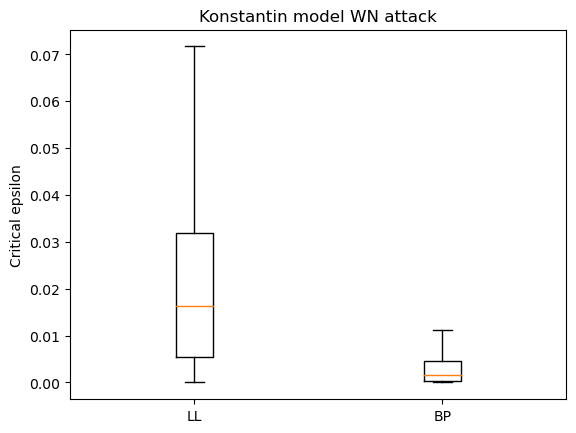

In [26]:
criteps_bp = critical_epsilon("correct", bp_modelK, "WN", print_accuracy=print_accuracy)
criteps_ll = critical_epsilon("correct", ll_modelK, "WN", print_accuracy=print_accuracy)
boxplot(criteps_ll, criteps_bp, "WN")

In [32]:
criteps_bp = critical_epsilon("correct", bp_modelK, "PGD", print_accuracy=print_accuracy)
criteps_ll = critical_epsilon("correct", ll_modelK, "PGD", print_accuracy=print_accuracy)
boxplot(criteps_ll, criteps_bp, "PGD")

RuntimeError: CUDA out of memory. Tried to allocate 40.00 MiB (GPU 0; 23.70 GiB total capacity; 21.50 GiB already allocated; 22.81 MiB free; 22.66 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

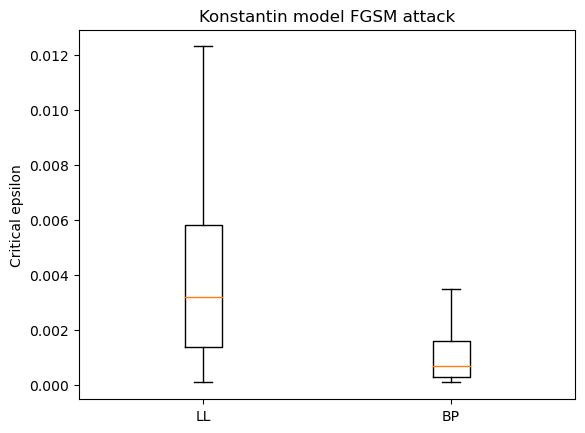

In [20]:
criteps_bp = critical_epsilon("correct", bp_modelK, "FGSM", print_accuracy=print_accuracy)
criteps_ll = critical_epsilon("correct", ll_modelK, "FGSM", print_accuracy=print_accuracy)
boxplot(criteps_ll, criteps_bp, "FGSM")